In [2]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

In [4]:
import torch
from torch import nn
from torch import optim

In [6]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.autoregressive import MaskedPiecewiseQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline
from nflows.transforms.dequantization import UniformDequantization

In [8]:
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.distributions.normal import StandardNormal
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform

In [10]:
x_prob = np.random.rand(10)
p_labels = x_prob/(np.sum(x_prob))
p_cum_labels = np.cumsum(p_labels)

In [12]:
# Define some arbitrary probability distribution
def p(x,y):
    if np.all(x > 0) and np.all(x < 1):
        return m.exp(-np.sum(x)/len(x)) * np.cos(y*m.pi*np.sum(x))**2
    return 0

def generate(n, d):
    x = np.zeros((n,d+1))

    counter = 0
    while(counter < n):
        label = np.argmax(r.random() < p_cum_labels)

        while(True):
            # Get a point
            x_trial = np.random.rand(d)
            if r.random() < p(x_trial, label):
                x[counter][:-1] = x_trial
                x[counter][-1] = label
                counter += 1
                break

    return x

In [14]:
num_layers = 5
base_dist = BoxUniform(torch.zeros(3), torch.ones(3))

transforms = []
transforms.append(UniformDequantization(max_labels=torch.tensor([-1,-1,9])))
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=3))
    transforms.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=3, 
        hidden_features=25,
        num_bins=25,
        num_blocks=4,
    ))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [15]:
num_iter = 25000
batch_size = 500
for i in range(num_iter):
    x = generate(batch_size, 2)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i % 500 == 0):
        print(loss.item())

0.9183108806610107


KeyboardInterrupt: 

In [29]:
n_events = 1000000
x_truth = generate(n_events, 2)
with torch.no_grad():
    x_flow = flow.sample(n_events).numpy()

derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)
derivs tensor(0.3344) tensor(0.8753)
what tensor(0.8743)


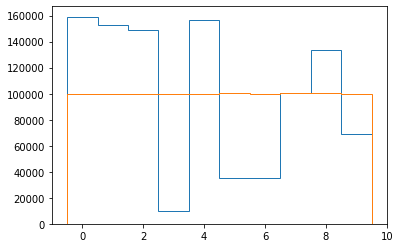

In [30]:
plt.hist(x_truth[:,2], histtype="step", bins = np.linspace(-0.5, 9.5, num=11))
plt.hist(x_flow[:,2], histtype="step", bins = np.linspace(-0.5, 9.5, num=11))
plt.show()

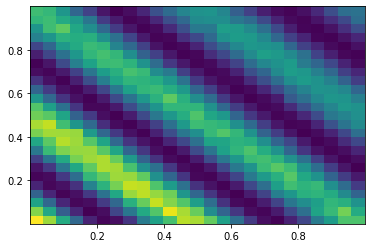

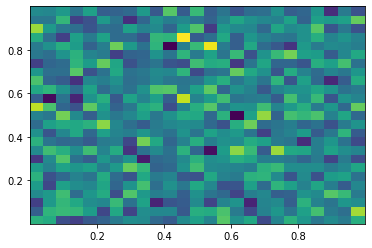

In [31]:
x_truth_0 = x_truth[x_truth[:,2] == 2]
x_flow_0  = x_flow[x_flow[:,2] == 2]
plt.hist2d(x_truth_0[:,0], x_truth_0[:,1], bins = 25)
plt.show()
plt.hist2d(x_flow_0[:,0], x_flow_0[:,1], bins = 25)
plt.show()